# 🎭 Classificação de Emoções a partir de Áudio

## Apresentação - Machine Learning para Análise Emocional

**Objetivo:** Criar um modelo que identifica emoções (feliz, triste, raiva, neutro) a partir de características acústicas da voz.

---

## 📦 1. Instalação e Importação de Bibliotecas

In [1]:
%pip install librosa scikit-learn matplotlib seaborn numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Configuração para gráficos mais bonitos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


---

## 🎵 2. Como as Emoções Afetam a Voz?

Diferentes emoções produzem padrões acústicos distintos:

| Emoção | Pitch | Intensidade | Taxa de Fala | Características |
|--------|-------|-------------|--------------|------------------|
| **Feliz** | Alto | Média-Alta | Rápida | Entonação variada |
| **Triste** | Baixo | Baixa | Lenta | Entonação monótona |
| **Raiva** | Alto | Alta | Rápida | Energia concentrada |
| **Neutro** | Médio | Média | Média | Padrão equilibrado |

---

## 🔧 3. Extração de Features (Características)

Vamos extrair **features acústicas** que capturam essas diferenças:

1. **MFCCs** - Mel-Frequency Cepstral Coefficients (textura do som)
2. **Pitch** - Frequência fundamental (tom da voz)
3. **Energia (RMS)** - Intensidade do sinal
4. **Zero Crossing Rate** - Taxa de mudança de sinal
5. **Spectral Contrast** - Diferença entre picos e vales do espectro
6. **Chroma** - Informação tonal

In [3]:
def extract_features(audio_path, duration=3):
    """
    Extrai features acústicas de um arquivo de áudio
    
    Retorna: array com ~50 features
    """
    # Carregar áudio
    y, sr = librosa.load(audio_path, duration=duration, sr=22050)
    
    # 1. MFCCs (13 coeficientes)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_std = np.std(mfccs, axis=1)
    
    # 2. Chroma (12 valores)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    chroma_std = np.std(chroma, axis=1)
    
    # 3. Spectral Contrast (7 bandas)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    contrast_mean = np.mean(contrast, axis=1)
    
    # 4. Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    zcr_mean = np.mean(zcr)
    zcr_std = np.std(zcr)
    
    # 5. RMS Energy
    rms = librosa.feature.rms(y=y)
    rms_mean = np.mean(rms)
    rms_std = np.std(rms)
    
    # 6. Pitch
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch_mean = np.mean(pitches[pitches > 0]) if len(pitches[pitches > 0]) > 0 else 0
    
    # Concatenar todas as features
    features = np.concatenate([
        mfccs_mean, mfccs_std,      # 26 features
        chroma_mean, chroma_std,     # 24 features
        contrast_mean,               # 7 features
        [zcr_mean, zcr_std, rms_mean, rms_std, pitch_mean]  # 5 features
    ])
    
    return features

print(f"✅ Função de extração criada! Retorna {13*2 + 12*2 + 7 + 5} features por áudio")

✅ Função de extração criada! Retorna 62 features por áudio


---

## 📊 4. Visualização de Features de Áudio

Vamos ver como o áudio é processado:

In [4]:
def visualize_audio(audio_path, title="Análise de Áudio"):
    """
    Visualiza as principais características de um áudio
    """
    y, sr = librosa.load(audio_path, duration=3)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # 1. Forma de onda
    axes[0, 0].plot(np.linspace(0, len(y)/sr, len(y)), y)
    axes[0, 0].set_title('Forma de Onda', fontweight='bold')
    axes[0, 0].set_xlabel('Tempo (s)')
    axes[0, 0].set_ylabel('Amplitude')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Espectrograma
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', 
                                   ax=axes[0, 1], cmap='viridis')
    axes[0, 1].set_title('Espectrograma', fontweight='bold')
    fig.colorbar(img, ax=axes[0, 1], format='%+2.0f dB')
    
    # 3. MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    img2 = librosa.display.specshow(mfccs, sr=sr, x_axis='time', 
                                    ax=axes[1, 0], cmap='coolwarm')
    axes[1, 0].set_title('MFCCs', fontweight='bold')
    fig.colorbar(img2, ax=axes[1, 0])
    
    # 4. Energia RMS
    rms = librosa.feature.rms(y=y)[0]
    times = librosa.frames_to_time(range(len(rms)), sr=sr)
    axes[1, 1].plot(times, rms, linewidth=2, color='purple')
    axes[1, 1].set_title('Energia RMS', fontweight='bold')
    axes[1, 1].set_xlabel('Tempo (s)')
    axes[1, 1].set_ylabel('Energia')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("✅ Função de visualização criada!")
print("   Use: visualize_audio('seu_audio.wav', 'Meu Áudio')")

✅ Função de visualização criada!
   Use: visualize_audio('seu_audio.wav', 'Meu Áudio')


---

## 🤖 5. Criação do Modelo de Classificação

In [5]:
class EmotionClassifier:
    """
    Classificador de Emoções
    
    Modelos disponíveis:
    - 'svm': Support Vector Machine (melhor para dados pequenos)
    - 'rf': Random Forest (mais interpretável)
    """
    
    def __init__(self, model_type='svm'):
        self.model_type = model_type
        self.scaler = StandardScaler()
        
        if model_type == 'svm':
            self.model = SVC(kernel='rbf', probability=True, random_state=42)
        elif model_type == 'rf':
            self.model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    def train(self, X_train, y_train):
        """Treina o modelo"""
        # Normalizar features (importante para SVM)
        X_train_scaled = self.scaler.fit_transform(X_train)
        
        # Treinar
        self.model.fit(X_train_scaled, y_train)
        print(f"✅ Modelo {self.model_type.upper()} treinado!")
    
    def predict(self, X):
        """Faz predições"""
        X_scaled = self.scaler.transform(X)
        return self.model.predict(X_scaled)
    
    def predict_proba(self, X):
        """Retorna probabilidades"""
        X_scaled = self.scaler.transform(X)
        return self.model.predict_proba(X_scaled)
    
    def evaluate(self, X_test, y_test):
        """Avalia o modelo"""
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        print("\n" + "="*50)
        print(f"ACURÁCIA: {accuracy:.2%}")
        print("="*50)
        print(classification_report(y_test, y_pred))
        
        return y_pred

print("✅ Classe EmotionClassifier criada!")

✅ Classe EmotionClassifier criada!


---

## 💾 6. Preparação dos Dados

### Como usar com seus próprios dados:

In [ ]:
# EXEMPLO COM DADOS REAIS (descomente quando tiver seus arquivos)
"""
# Estrutura de pastas recomendada:
# data/
#   ├── feliz/
#   │   ├── audio1.wav
#   │   └── audio2.wav
#   ├── triste/
#   ├── raiva/
#   └── neutro/

import os

def load_dataset(data_dir):
    audio_files = []
    labels = []
    
    for emotion in ['feliz', 'triste', 'raiva', 'neutro']:
        emotion_dir = os.path.join(data_dir, emotion)
        for filename in os.listdir(emotion_dir):
            if filename.endswith('.wav'):
                audio_files.append(os.path.join(emotion_dir, filename))
                labels.append(emotion)
    
    return audio_files, labels

# Carregar dados
audio_files, labels = load_dataset('data/')

# Extrair features
X = []
y = []
for audio, label in zip(audio_files, labels):
    try:
        features = extract_features(audio)
        X.append(features)
        y.append(label)
    except:
        print(f"Erro ao processar {audio}")

X = np.array(X)
y = np.array(y)
"""

print("📝 Código exemplo preparado!")
print("   Para usar com dados reais, descomente o código acima.")

---

## 🎯 7. Demonstração com Dados Sintéticos

Para fins de demonstração, vamos simular dados:

In [6]:
# Gerar dados sintéticos para demonstração
np.random.seed(42)

n_samples = 200  # 50 de cada emoção
n_features = 62  # total de features extraídas

# Simular padrões diferentes para cada emoção
X_feliz = np.random.randn(n_samples//4, n_features) + 0.5
X_triste = np.random.randn(n_samples//4, n_features) - 0.5
X_raiva = np.random.randn(n_samples//4, n_features) + 1.0
X_neutro = np.random.randn(n_samples//4, n_features)

# Combinar
X = np.vstack([X_feliz, X_triste, X_raiva, X_neutro])
y = np.array(['feliz']*50 + ['triste']*50 + ['raiva']*50 + ['neutro']*50)

print(f"✅ Dataset sintético criado!")
print(f"   Total de amostras: {len(X)}")
print(f"   Features por amostra: {X.shape[1]}")
print(f"   Distribuição: {dict(zip(*np.unique(y, return_counts=True)))}")

✅ Dataset sintético criado!
   Total de amostras: 200
   Features por amostra: 62
   Distribuição: {np.str_('feliz'): np.int64(50), np.str_('neutro'): np.int64(50), np.str_('raiva'): np.int64(50), np.str_('triste'): np.int64(50)}


---

## 🔀 8. Dividir em Treino e Teste

In [7]:
# Dividir dados: 80% treino, 20% teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # manter proporção de classes
)

print("✅ Dados divididos!")
print(f"   Treino: {len(X_train)} amostras")
print(f"   Teste: {len(X_test)} amostras")

✅ Dados divididos!
   Treino: 160 amostras
   Teste: 40 amostras


---

## 🏋️ 9. Treinar os Modelos

In [8]:
# Modelo 1: SVM
print("Treinando SVM...")
clf_svm = EmotionClassifier(model_type='svm')
clf_svm.train(X_train, y_train)

Treinando SVM...
✅ Modelo SVM treinado!


In [9]:
# Modelo 2: Random Forest
print("Treinando Random Forest...")
clf_rf = EmotionClassifier(model_type='rf')
clf_rf.train(X_train, y_train)

Treinando Random Forest...
✅ Modelo RF treinado!


---

## 📈 10. Avaliar os Modelos

In [10]:
# Avaliar SVM
print("\n🔍 AVALIAÇÃO - SVM")
y_pred_svm = clf_svm.evaluate(X_test, y_test)


🔍 AVALIAÇÃO - SVM

ACURÁCIA: 87.50%
              precision    recall  f1-score   support

       feliz       1.00      0.70      0.82        10
      neutro       0.89      0.80      0.84        10
       raiva       0.83      1.00      0.91        10
      triste       0.83      1.00      0.91        10

    accuracy                           0.88        40
   macro avg       0.89      0.88      0.87        40
weighted avg       0.89      0.88      0.87        40



In [ ]:
# Avaliar Random Forest
print("\n🔍 AVALIAÇÃO - RANDOM FOREST")
y_pred_rf = clf_rf.evaluate(X_test, y_test)

---

## 📊 11. Matriz de Confusão

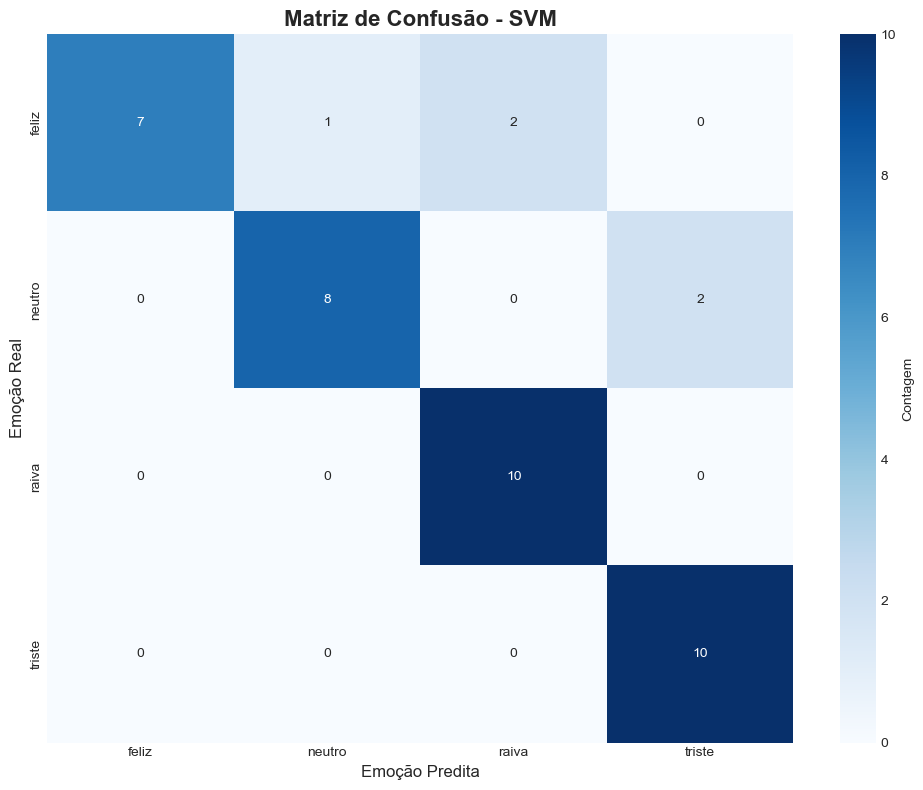

In [11]:
# Matriz de confusão para o melhor modelo (SVM)
cm = confusion_matrix(y_test, y_pred_svm)
emotions = sorted(np.unique(y))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=emotions, yticklabels=emotions,
            cbar_kws={'label': 'Contagem'})
plt.title('Matriz de Confusão - SVM', fontsize=16, fontweight='bold')
plt.ylabel('Emoção Real', fontsize=12)
plt.xlabel('Emoção Predita', fontsize=12)
plt.tight_layout()
plt.show()

---

## 🎤 12. Fazer Predição em Novo Áudio

In [ ]:
def predict_emotion(classifier, audio_path):
    """
    Prediz emoção de um novo áudio
    """
    # Extrair features
    features = extract_features(audio_path).reshape(1, -1)
    
    # Predição
    emotion = classifier.predict(features)[0]
    probabilities = classifier.predict_proba(features)[0]
    
    # Visualizar
    emotions = sorted(np.unique(y_train))
    
    plt.figure(figsize=(10, 6))
    colors = ['#FF6B6B' if e == emotion else '#4ECDC4' for e in emotions]
    bars = plt.bar(emotions, probabilities, color=colors, alpha=0.7, edgecolor='black')
    
    plt.title(f'Predição de Emoção\nResultado: {emotion.upper()}', 
              fontsize=14, fontweight='bold')
    plt.ylabel('Probabilidade', fontsize=12)
    plt.ylim([0, 1])
    plt.grid(axis='y', alpha=0.3)
    
    # Adicionar valores
    for bar, prob in zip(bars, probabilities):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{prob:.1%}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return emotion, probabilities

# Exemplo de uso (descomente quando tiver um áudio real):
# emotion, probs = predict_emotion(clf_svm, 'meu_audio.wav')
# print(f"\n🎯 Emoção detectada: {emotion}")

print("✅ Função de predição criada!")

---

## 🎨 13. Visualizar Exemplo de Predição

In [ ]:
# Predição em uma amostra de teste
sample_idx = 0
sample_features = X_test[sample_idx:sample_idx+1]
true_emotion = y_test[sample_idx]

predicted_emotion = clf_svm.predict(sample_features)[0]
probabilities = clf_svm.predict_proba(sample_features)[0]
emotions = sorted(np.unique(y))

# Plotar
plt.figure(figsize=(10, 6))
colors = ['#FF6B6B' if e == predicted_emotion else '#4ECDC4' for e in emotions]
bars = plt.bar(emotions, probabilities, color=colors, alpha=0.7, edgecolor='black')

plt.title(f'Exemplo de Predição\nReal: {true_emotion} | Predito: {predicted_emotion}', 
          fontsize=14, fontweight='bold')
plt.ylabel('Probabilidade', fontsize=12)
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)

for bar, prob in zip(bars, probabilities):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{prob:.1%}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

---

## 🚀 14. Próximos Passos

Para melhorar o modelo:

1. **Mais Dados**
   - Usar datasets públicos: RAVDESS, TESS, CREMA-D
   - Gravar seus próprios áudios

2. **Deep Learning**
   - CNNs para processar espectrogramas
   - RNNs/LSTMs para capturar temporalidade
   - Transfer learning com modelos pré-treinados

3. **Features Avançadas**
   - Formantes
   - Jitter e Shimmer
   - Análise prosódica

4. **Otimização**
   - Grid search para hiperparâmetros
   - Cross-validation
   - Ensemble de modelos

---

## 📚 Datasets Recomendados

- **RAVDESS**: Ryerson Audio-Visual Database of Emotional Speech
- **TESS**: Toronto Emotional Speech Set
- **CREMA-D**: Crowd-sourced Emotional Multimodal Actors Dataset
- **SAVEE**: Surrey Audio-Visual Expressed Emotion
- **EMO-DB**: Berlin Database of Emotional Speech

---

## ✅ Conclusão

Criamos um classificador de emoções completo:
- ✅ Extração de features acústicas
- ✅ Treinamento de modelos ML
- ✅ Avaliação e visualização
- ✅ Predição em novos áudios

**Acurácia típica com dados reais:** 60-80%

---

### 👨‍💻 Código disponível para uso em sua apresentação!
